d:\ana\envs\dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


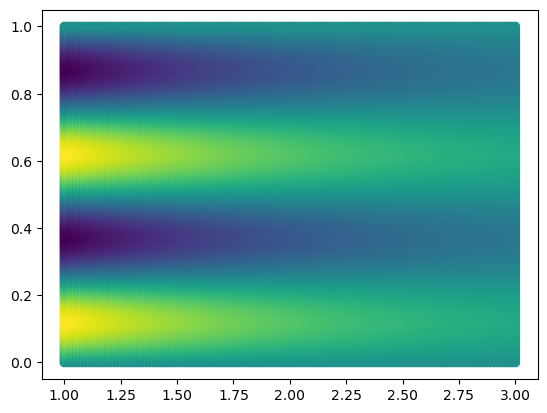

In [1]:
import sys
sys.path.append('../../')

import numpy as np
import torch
import matplotlib
np.random.seed(1)
torch.manual_seed(1)

from user_funn.field import D2Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.pde import grad
from user_funn.geom import line_linspace

# define question
n = 4
a = 0.005
L = 1
tmax = 3

# get ana-solution
import heat_benchmark 
bm = heat_benchmark.HeatBenchMark(n,a,L,tmax)
X,y_true = bm.gen_testdata()
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c = y_true)


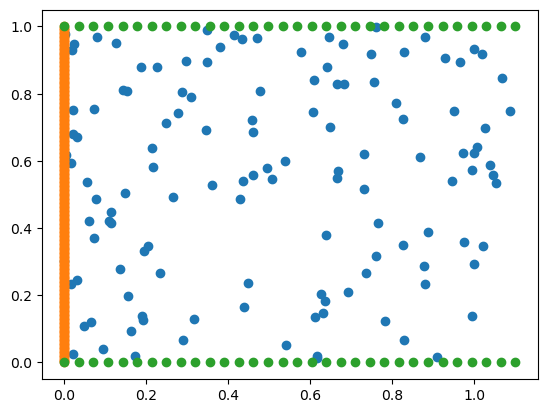

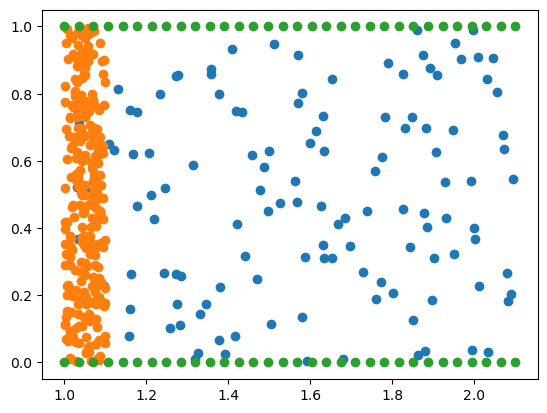

In [2]:
# 保证迭代参数与DEEPXDE一致
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = torch.nn.MSELoss()

# hyperparameter config
T_iter = 3
t_length_per_iter = 1

t_span_start_list, overlap_start_list, t_span_end_list = [], [], []
pde_input_list,pde_output_list = [],[]
tc_input_list,tc_output_list = [],[]
bc_input_list,bc_output_list = [],[]

pde_epoch_size = 128
bc_epoch_size = 64
tc_epoch_size = 256

overlap_length = 0.1
for T_id in range(T_iter):
    t_span_start = T_id
    overlap_start = T_id+1
    t_span_end = (T_id+1) + overlap_length 
    t_span_start_list.append(t_span_start)
    overlap_start_list.append(overlap_start)
    t_span_end_list.append(t_span_end)
    
    pde_field = D2Field([t_span_start,t_span_end],[0,L])
    pde_input = pde_field.get_field_rand(pde_epoch_size)
    pde_output = np.zeros([pde_epoch_size,1])
    pde_input_list.append(pde_input)
    pde_output_list.append(pde_output)

    # define bc_input and bc_output 
    bc_input1 = line_linspace([t_span_start,0],[t_span_end,0],bc_epoch_size//2)
    bc_input2 = line_linspace([t_span_start,L],[t_span_end,L],bc_epoch_size//2)
    bc_input = np.vstack([bc_input1,bc_input2])
    bc_output = np.zeros([bc_epoch_size ,1])
    bc_input_list.append(bc_input)
    bc_output_list.append(bc_output)

    # define tc_input and tc_output
    if T_id == 0:
        tc_input = line_linspace([0,0],[0,L],tc_epoch_size)
    else:
        tc_field = D2Field([t_span_start, t_span_start+ overlap_length],[0,L])
        tc_input = tc_field.get_field_rand(tc_epoch_size)

    tc_input_list.append(tc_input)

tc_input_init = line_linspace([0,0],[0,L],tc_epoch_size)

tc_t = tc_input_init[:,0]
tc_x = tc_input_init[:,1]

tc_output_init = np.sin(n * np.pi * tc_x / L).reshape(tc_epoch_size,1)


# define loss
def pde_loss(model, data):
    x_in,y_real = data
    x_in.requires_grad=True
    U = model(x_in)
    # 数据提取
    t = x_in[:,[0]]
    x = x_in[:,[1]]
    u = U[:,[0]]
    # 计算一阶导
    dudi = grad(u, x_in)[0]
    dudt = dudi[:,[0]]
    dudx = dudi[:,[1]]
    # 计算二阶导
    du2dxi = grad(dudx, x_in)[0]
    du2dx2 = du2dxi[:,[1]]
    loss = dudt - a * du2dx2
    loss = loss_fn(loss, y_real)
    return loss

from user_funn.bc import data_loss_factory
tc_loss = data_loss_factory(loss_fn,[0])
bc_loss = data_loss_factory(loss_fn,[0])


import user_funn.plot
user_funn.plot.scatter_2d_cloud_point_kind(
    [pde_input_list[0], tc_input_list[0], bc_input_list[0]])
user_funn.plot.scatter_2d_cloud_point_kind(
    [pde_input_list[1], tc_input_list[1], bc_input_list[1]])
# user_funn.plot.scatter_2d_cloud_point_kind(
#     [pde_input_list[2], tc_input_list[2], bc_input_list[2]])


In [3]:
# INIT:BEGIN
# 1. (pde_input_list,pde_output_list,bc_input_list,bc_output_list,tc_input_list)
#    已经在前段生成
# 2. 建立网络
solver_list = []
for T_id in range(T_iter):
    solver_list.append(
        CloudPointSolver(model = [2, 32, 32, 32, 1],optimizer = "adam")
    )
# INIT:END

# TRAIN:BEGIN
epoch_num = 6000
cloud_point_list = [None for i in range(T_iter)]
for epoch_id in range(epoch_num):
    for use_model_id in range(T_iter):
        t_span_start = use_model_id
        overlap_start = use_model_id+1
        t_span_end = (use_model_id+1) + overlap_length 


        # 通信周期
        if epoch_id % 10 == 0:
            seg_start = np.array([t_span_start,0]).reshape(1,2)

            if use_model_id == 0:
                tc_output = tc_output_init
            else:
                tc_output =\
                    solver_list[use_model_id-1].model_eval(
                        tc_input_list[use_model_id] \
                        - seg_start + np.array([1,0]).reshape(1,2))
            
            cloud_point_list[use_model_id] = [
                [pde_input_list[use_model_id] - seg_start,
                    pde_output_list[use_model_id]],
                [tc_input_list[use_model_id] - seg_start,
                    tc_output],
                [bc_input_list[use_model_id] - seg_start, 
                    bc_output_list[use_model_id]]
            ]
        
        # 测试周期
        if epoch_id % 100 == 0:
            print(f'model{use_model_id}',end ='')
            solver_list[use_model_id].test_step(
                cloud_point_list = cloud_point_list[use_model_id],
                loss_list = [pde_loss, tc_loss, bc_loss],
                batchsize = [pde_epoch_size, tc_epoch_size, bc_epoch_size],
                loss_weight_list = [1,1,1],
                print_flag=True)
            

        solver_list[use_model_id].train_step(
            cloud_point_list = cloud_point_list[use_model_id],
            loss_list = [pde_loss, tc_loss, bc_loss],
            batchsize = [pde_epoch_size, tc_epoch_size, bc_epoch_size],
            loss_weight_list = [1,1,1])
    
# TRAIN:END

model0loss is [0.00984548 0.5204766  0.02358688 0.55390894]
model1loss is [0.00102417 0.08643469 0.01497665 0.10243551]
model2loss is [0.00033188 0.04430862 0.00507881 0.0497193 ]
model0loss is [0.00221589 0.4575742  0.01270447 0.47249454]
model1loss is [0.00156107 0.01489034 0.00699111 0.02344252]
model2loss is [0.0007049  0.02072652 0.00334342 0.02477485]
model0loss is [0.0057559  0.45346218 0.01136195 0.47058004]
model1loss is [3.7198835e-05 2.1949076e-04 3.3398240e-04 5.9067202e-04]
model2loss is [0.0002022  0.00182607 0.00097561 0.00300388]
model0loss is [0.00597868 0.45300144 0.01131373 0.47029385]
model1loss is [1.6213271e-05 4.5867328e-04 1.2406681e-04 5.9895334e-04]
model2loss is [5.6907828e-07 4.8814767e-05 2.1816304e-05 7.1200149e-05]
model0loss is [0.00611394 0.4527943  0.01129618 0.47020444]
model1loss is [1.6695714e-05 4.9350294e-04 1.4644008e-04 6.5663876e-04]
model2loss is [3.1299587e-06 4.2087071e-05 1.7965722e-05 6.3182750e-05]
model0loss is [0.00616367 0.45271206 0.0

C:\Users\hpc\AppData\Local\Temp\ipykernel_98420\263909781.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if x_all == []:


error 0.010352777976738657


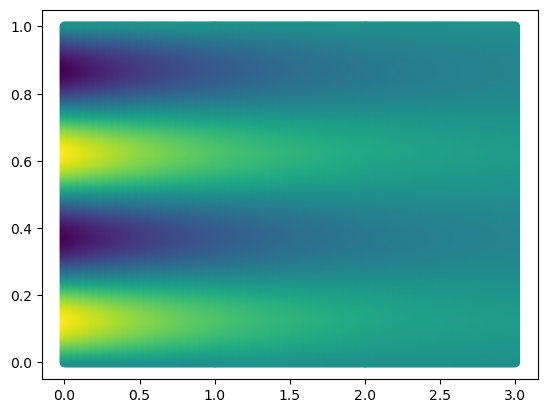

In [4]:
# EVAL:BEGIN
x_all = []
y_all = []
for model_id in range(T_iter):
    ## define a pde
    t_span_start = model_id
    t_span_end = model_id+1

    seg_start = np.array([t_span_start,0]).reshape(1,2)

    x_cpu,y_real = heat_benchmark.HeatBenchMark(n,a,L,
        tmin = t_span_start, tmax = t_span_end).gen_testdata()

    y_pred = solver_list[model_id].model_eval(x_cpu - seg_start, \
        use_best_model_flag = False)

    if x_all == []:
        x_all = x_cpu
        y_pred_all = y_pred
        y_real_all = y_real
    else:
        x_all = np.vstack([x_all,x_cpu])
        y_pred_all = np.vstack([y_pred_all,y_pred])
        y_real_all = np.vstack([y_real_all, y_real])

# EVAL:END

import matplotlib.pyplot as plt
plt.scatter(x_all[:,0],x_all[:,1],c = y_pred_all)
print('error',np.abs(y_real_all-y_pred_all).std()/y_real_all.std())